# Evaluating the average privacy loss of a training algorithm

In this tutorial, we will see how to evaluate the average privacy loss of a training algorithm, regarding a membership inference game. To do so, we will train a PyTorch classifier on the Purchase100 dataset multiple time, and use the `privacy_meter` tool to display information about the privacy leakage. We will use the simple shadow metric, which makes use of shadow models.

Among other things, we will cover:
* Creating a Dataset object from a custom dataset
* Auditing multiple PyTorch models trained with the same algorithm at once
* Visualizing key information about privacy leakage

<table class="tfo-notebook-buttons" align="left">
<td>
    <a target="_blank" href="https://colab.research.google.com/github/privacytrustlab/ml_privacy_meter/blob/d32734161a3395211fe5f3cd461932290b1fafbe/advanced/avg_loss_training_algo.ipynb?authuser=2"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/privacytrustlab/ml_privacy_meter/blob/master/advanced/avg_loss_training_algo.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View GitHub</a>
  </td>
</table>

## Imports

In [4]:
from math import ceil
import random

In [5]:
import numpy as np
import torch
from torch import nn, optim, Tensor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

For now we install the library from the local source. A version will be pushed to pip soon.

In [10]:
!git clone https://github.com/privacytrustlab/ml_privacy_meter.git

Cloning into 'ml_privacy_meter'...
remote: Enumerating objects: 3113, done.
remote: Counting objects: 100% (476/476), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 3113 (delta 389), reused 371 (delta 363), pack-reused 2637 (from 1)
Receiving objects: 100% (3113/3113), 61.03 MiB | 27.63 MiB/s, done.
Resolving deltas: 100% (2001/2001), done.


In [11]:
%cd ml_privacy_meter

/content/ml_privacy_meter/ml_privacy_meter


In [13]:
!git checkout d32734161a3395211fe5f3cd461932290b1fafbe

HEAD is now at d327341 Update README.md


In [14]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of functorch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 821.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.9/216.9 kB 14

In [1]:
import sys
sys.path.append('/content/ml_privacy_meter')

In [2]:
import sys
!{sys.executable} -m pip install -e ../.

from privacy_meter.audit import Audit
from privacy_meter.audit_report import ROCCurveReport, SignalHistogramReport
from privacy_meter.constants import InferenceGame
from privacy_meter.dataset import Dataset
from privacy_meter.hypothesis_test import threshold_func
from privacy_meter.information_source import InformationSource
from privacy_meter.information_source_signal import ModelLoss
from privacy_meter.metric import ShadowMetric
from privacy_meter.model import PytorchModel

Obtaining file:///
ERROR: file:/// does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


## Settings

We set a fixed seed for reproducibility:

In [6]:
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

And we set some hyperparameters:

In [7]:
N_TRAININGS = 5      # Number of rounds
N_SHADOW_MODELS = 3  # Number of shadow models per round
EPOCHS = 10          # Number of epochs
BATCH_SIZE = 32      # Batch size for the training

## Dataset creation

Let’s download the Purchase100 dataset (presented in https://www.cs.cornell.edu/~shmat/shmat_oak17.pdf on page 7) and extract it:

In [8]:
!wget https://github.com/privacytrustlab/datasets/raw/master/dataset_purchase.tgz
!tar -xvzf dataset_purchase.tgz
!rm dataset_purchase.tgz

--2024-11-03 07:30:11--  https://github.com/privacytrustlab/datasets/raw/master/dataset_purchase.tgz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/privacytrustlab/datasets/master/dataset_purchase.tgz [following]
--2024-11-03 07:30:11--  https://raw.githubusercontent.com/privacytrustlab/datasets/master/dataset_purchase.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22045876 (21M) [application/octet-stream]
Saving to: ‘dataset_purchase.tgz’

dataset_purchase.tg 100%[===================>]  21.02M  --.-KB/s    in 0.1s    

2024-11-03 07:30:12 (145 MB/s) - ‘dataset_purchase.tgz’ saved [2204587

Bellow, we use the `preprocess_purchase100` function to read and preprocess the dataset.

In [9]:
def preprocess_purchase100():
    """
    Cf. https://www.cs.cornell.edu/~shmat/shmat_oak17.pdf page 7
    Returns:
        The dataset, in the form x_train, y_train, x_test, y_test
    """
    # Read raw dataset
    dataset_path = "dataset_purchase"
    with open(dataset_path, "r") as f:
        purchase_dataset = f.readlines()
    # Separate features and labels into different arrays
    x, y = [], []
    for datapoint in purchase_dataset:
        split = datapoint.rstrip().split(",")
        label = int(split[0]) - 1  # The first value is the label
        features = np.array(split[1:], dtype=np.float32)  # The next values are the features
        x.append(features)
        y.append(label)
    # Make sure the datatype is correct
    x = np.array(x, dtype=np.float32)
    # Convert labels into one hot vectors
    y = OneHotEncoder(sparse=False).fit_transform(np.expand_dims(y, axis=1))
    # Split data into train, test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1234)
    return x_train, y_train, x_test, y_test

The `generate_splits` creates a Dataset object, and uses the built-in `subdivide` function to split this dataset into multiple independent ones, to train the target model and the shadow models.

In [10]:
def generate_splits(x_train, y_train, x_test, y_test, n_shadow_models):
    dataset = Dataset(
        data_dict={'train': {'x': x_train, 'y': y_train}, 'test': {'x': x_test, 'y': y_test}},
        default_input='x',
        default_output='y'
    )
    datasets_list = dataset.subdivide(
        num_splits=n_shadow_models + 1,
        return_results=True,
        method='independent'
    )
    return datasets_list

Finally, the `generate_datasets` function puts it all together, and generate a list of datasets (or rather of splits of the Purchase100 dataset), ready to be used for training.

In [11]:
def generate_datasets(n_trainings, n_shadow_models):
    x_train, y_train, x_test, y_test = preprocess_purchase100()
    datasets_lists = [generate_splits(x_train, y_train, x_test, y_test, n_shadow_models) for _ in range(n_trainings)]
    return datasets_lists

## Models training

We start with the `get_torch_models` function, which returns a 2D list of models. The 1st dimension corresponds to the different rounds we do to get the average privacy loss of the training algorithm. The 2nd dimension corresponds to the different models used in one round: index 0 is the target model, while indices >0 are the shadow models.

In [12]:
def get_torch_models(n_trainings, n_shadow_models):
    torch_models = [[
        nn.Sequential(
            nn.Linear(in_features=600, out_features=350),
            nn.Tanh(),
            nn.Linear(in_features=350, out_features=100)
        )
        for _ in range(n_shadow_models + 1)
        ] for _ in range(n_trainings)
    ]
    return torch_models

Then the `get_trained_torch_models` function takes those raw models, and train them using the previously generated datasets list.

In [13]:
def get_trained_torch_models(n_trainings, n_shadow_models, criterion, datasets_lists, batch_size, epochs):
    torch_models = get_torch_models(n_trainings, n_shadow_models)
    for i in range(n_trainings):
        for j in range(n_shadow_models + 1):
            optimizer = optim.Adam(torch_models[i][j].parameters())
            x = datasets_lists[i][j].get_feature(split_name=f'train', feature_name='<default_input>')
            y = datasets_lists[i][j].get_feature(split_name=f'train', feature_name='<default_output>')
            n_samples = x.shape[0]
            n_batches = ceil(n_samples / batch_size)
            x = np.array_split(x, n_batches)
            y = np.array_split(y, n_batches)
            for epoch in range(epochs):
                epoch_loss, acc = 0.0, 0.0
                for b in range(n_batches):
                    optimizer.zero_grad()
                    y_pred = torch_models[i][j](Tensor(x[b]))
                    loss = criterion(y_pred, Tensor(y[b]))
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()
                    acc += torch.sum(y_pred.argmax(axis=1) == Tensor(y[b]).argmax(axis=1))
                acc /= n_samples
                epoch_loss /= n_samples
                print(f'round #{i+1:02d}/{n_trainings:02d}, model #{j+1:02d}/{n_shadow_models+1:02d}, epoch #{epoch+1:02d}/{epochs:02d}:\ttrain_acc = {acc:.3f}\ttrain_loss = {epoch_loss:.3e}')
    return torch_models

And finally the `get_models` function puts it all together, by generating the models, training them, and wrapping them `PytorchModel` objects, provided by the `privacy_meter` tool.

In [14]:
def get_models(n_trainings, n_shadow_models, datasets_lists, batch_size, epochs):
    criterion = nn.CrossEntropyLoss(reduction='sum')
    torch_models = get_trained_torch_models(n_trainings, n_shadow_models, criterion, datasets_lists, batch_size, epochs)
    models = [[
        PytorchModel(
            model_obj=torch_models[i][j],
            loss_fn=criterion
        )
        for j in range(n_shadow_models + 1)
        ] for i in range(n_trainings)
    ]
    return models

## Auditing

Now that we have both the datasets and the trained model, we can start the actual auditing. We get started by wrapping those in two `InformationSource` objects, an interface provided by the `privacy_meter` tool.

In [15]:
def get_info_sources(models, datasets_lists, n_trainings):
    target_info_sources = [InformationSource(
        models=[models[i][0]],
        datasets=[datasets_lists[i][0]]
        ) for i in range(n_trainings)
    ]
    reference_info_sources = [InformationSource(
        models=models[i][1:],
        datasets=datasets_lists[i][1:]
        ) for i in range(n_trainings)
    ]
    return target_info_sources, reference_info_sources

The final step before running the auditing algorithm is to create some `Metric` objects, which represent the algorithm to use for the membership inference attack. As mentioned in the introduction, here, we use the `ShadowMetric` one, which makes use of shadow models.

In [16]:
def get_metrics(models, datasets_lists, n_trainings):
    target_info_sources, reference_info_sources = get_info_sources(models, datasets_lists, n_trainings)
    metrics = [ShadowMetric(
        target_info_source=target_info_sources[i],
        reference_info_source=reference_info_sources[i],
        signals=[ModelLoss()],
        hypothesis_test_func=threshold_func,
        unique_dataset=False,
        reweight_samples=True
    ) for i in range(n_trainings)]
    return metrics

We now have everything we need. The `get_audit_results` puts everything together, by calling the datasets related functions, the models related functions, and metrics related function, and by running the actual auditing.

In [17]:
def get_audit_results(n_trainings, n_shadow_models, batch_size, epochs):
    datasets_lists = generate_datasets(n_trainings, n_shadow_models)
    models = get_models(n_trainings, n_shadow_models, datasets_lists, batch_size, epochs)
    metrics = get_metrics(models, datasets_lists, n_trainings)
    audit = Audit(
        metrics=metrics,
        inference_game_type=InferenceGame.AVG_PRIVACY_LOSS_TRAINING_ALGO
    )
    audit.prepare()
    results = audit.run()
    return results

In [18]:
results = get_audit_results(N_TRAININGS, N_SHADOW_MODELS, BATCH_SIZE, EPOCHS)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


round #01/05, model #01/04, epoch #01/10:	train_acc = 0.634	train_loss = 1.352e+00
round #01/05, model #01/04, epoch #02/10:	train_acc = 0.850	train_loss = 4.968e-01
round #01/05, model #01/04, epoch #03/10:	train_acc = 0.925	train_loss = 3.037e-01
round #01/05, model #01/04, epoch #04/10:	train_acc = 0.971	train_loss = 1.874e-01
round #01/05, model #01/04, epoch #05/10:	train_acc = 0.991	train_loss = 1.153e-01
round #01/05, model #01/04, epoch #06/10:	train_acc = 0.997	train_loss = 7.430e-02
round #01/05, model #01/04, epoch #07/10:	train_acc = 0.996	train_loss = 5.605e-02
round #01/05, model #01/04, epoch #08/10:	train_acc = 0.996	train_loss = 4.613e-02
round #01/05, model #01/04, epoch #09/10:	train_acc = 0.994	train_loss = 4.248e-02
round #01/05, model #01/04, epoch #10/10:	train_acc = 0.995	train_loss = 3.259e-02
round #01/05, model #02/04, epoch #01/10:	train_acc = 0.633	train_loss = 1.350e+00
round #01/05, model #02/04, epoch #02/10:	train_acc = 0.851	train_loss = 4.939e-01
roun

KeyboardInterrupt: 

## Results visualization

The `get_audit_results` function returns a list of results, one per round. We can start by displaying them individually:

In [ ]:
for result in results:
    print(result)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.4612016540987594
ROC AUC Score     = 0.521984208772436
FPR               = 0.35165815292305197
TN, FP, FN, TP    = (7996, 4337, 22243, 14756)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.44530933268466716
ROC AUC Score     = 0.5144575053622639
FPR               = 0.35165815292305197
TN, FP, FN, TP    = (7996, 4337, 23027, 13972)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.4428768345090408
ROC AUC Score     = 0.5123275019889114
FPR               = 0.3476850725695289
TN, FP, FN, TP    = (8045, 4288, 23196, 13803)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.4697762101678424
ROC AUC Score     = 0.5186156402766726
FPR               = 0.3836049622962783
TN, FP, FN, TP    = (7602, 4731, 21426, 15573)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.4499918916727479
ROC AUC Score     = 0.5206481416667897
FPR               =

We can also use built-in visualizations from the `privacy_meter` tool, to get easily interpretable aggregates:

In [ ]:
# This instruction won't be needed once the tool is on pip
from privacy_meter import audit_report
audit_report.REPORT_FILES_DIR = '../privacy_meter/report_files'

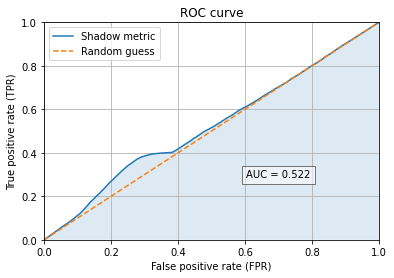

<Figure size 432x288 with 0 Axes>

In [ ]:
ROCCurveReport.generate_report(
    metric_result=results,
    inference_game_type=InferenceGame.AVG_PRIVACY_LOSS_TRAINING_ALGO,
    save=False,
    show=True
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


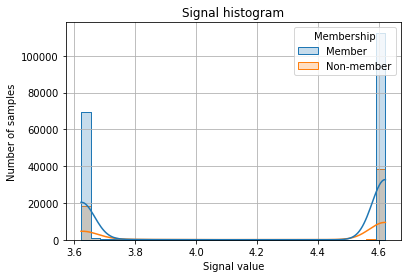

<Figure size 432x288 with 0 Axes>

In [ ]:
SignalHistogramReport.generate_report(
    metric_result=results,
    inference_game_type=InferenceGame.AVG_PRIVACY_LOSS_TRAINING_ALGO,
    save=False,
    show=True
)